<a href="https://colab.research.google.com/github/Anish7-anish/BTEC-State-Detection/blob/main/HPW_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install schedule

**Essential Libraries and Modules**

In [2]:
import requests
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, InputLayer
import json
from dateutil import tz
from datetime import timedelta
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from datetime import datetime, timedelta
import pytz
from dateutil import parser
import io
from email.mime.image import MIMEImage
import schedule
import time

**Secure Token Retrieval for GraphQL Authentication Using JWTold text**

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

def get_bearer_token(auth, password, name, role, url):
    # Form and send the GraphQL request for authentication
    auth_query = f"""
        mutation authRequest {{
            authenticationRequest(
                input: {{authenticator: "{auth}", role: "{role}", userName: "{name}"}}
            ) {{
                jwtRequest {{
                    challenge, message
                }}
            }}
        }}
    """
    auth_response = requests.post(url, json={'query': auth_query})
    auth_response.raise_for_status()
    jwt_request = auth_response.json()['data']['authenticationRequest']['jwtRequest']
    if jwt_request['challenge'] is None:
        raise requests.exceptions.HTTPError(jwt_request['message'])

    # Form and send the GraphQL request for the token validation
    validation_query = f"""
        mutation authValidation {{
            authenticationValidation(
                input: {{authenticator: "{auth}", signedChallenge: "{jwt_request['challenge']}|{password}"}}
            ) {{
                jwtClaim
            }}
        }}
    """
    validation_response = requests.post(url, json={'query': validation_query})
    validation_response.raise_for_status()
    jwt_claim = validation_response.json()['data']['authenticationValidation']['jwtClaim']
    return f"Bearer {jwt_claim}"

****

**Enhanced GraphQL Request Handling with Token Management and Error Control**

In [4]:
def perform_graphql_request(query, url, auth, password, name, role, current_token=None):
    # If no token was provided or if the token is expired, get a new one
    if current_token is None:
        current_token = get_bearer_token(auth, password, name, role, url)
    headers = {"Authorization": current_token}

    # Perform the request with the token
    response = requests.post(url, json={'query': query}, headers=headers)
    if response.status_code == 401:  # Unauthorized, token has expired
        current_token = get_bearer_token(auth, password, name, role, url)
        headers = {"Authorization": current_token}
        response = requests.post(url, json={'query': query}, headers=headers)

    response.raise_for_status()  # Raises an HTTPError for bad responses
    return response.json()

**Data Preprocessing**

In [5]:
def preprocess_realtime_data(data, sequence_length):
    # Convert string values to 'Off' and 'On' for RO_Skid_Running column
    for ts, entry in data.items():
        if entry["RO_Skid_Running"] == "None":
            entry["RO_Skid_Running"] = np.nan
        elif entry["RO_Skid_Running"] == "0":
            entry["RO_Skid_Running"] = "Off"
        elif entry["RO_Skid_Running"] == "1":
            entry["RO_Skid_Running"] = "On"

    # Convert 'None' or NaN values to np.nan for Level_PV column
    for ts, entry in data.items():
        if entry["Level_PV"] is None or np.isnan(entry.get("Level_PV", np.nan)):
            entry["Level_PV"] = np.nan

    # Convert data to DataFrame for better visualization
    df = pd.DataFrame.from_dict(data, orient='index')

    # Forward fill the missing values for "Level_PV" and "RO_Skid_Running"
    df['Level_PV'] = df['Level_PV'].fillna(method='ffill')
    df['RO_Skid_Running'] = df['RO_Skid_Running'].fillna(method='ffill')

    # After forward fill, if there are still NaNs at the start, fill with the first non-NaN value
    df['Level_PV'].fillna(method='bfill', inplace=True)
    df['RO_Skid_Running'].fillna(method='bfill', inplace=True)

    # Create sequences of the same length as model input sequence length
    X_realtime = []
    timestamps = list(df.index)  # Keep track of timestamps to maintain the integrity of sequences

    for i in range(len(df) - sequence_length + 1):
        sequence = [df['Level_PV'].iloc[j] for j in range(i, i + sequence_length)]
        X_realtime.append(sequence)

    return np.array(X_realtime), df

**Json File Generation and Loading**

In [6]:
def save_state_info(state_info, file_path='state_info.json'):
    with open(file_path, 'w') as file:
        json.dump(state_info, file)

def load_state_info(file_path='state_info.json'):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        return {"current_state": "normal", "last_state_change_time": datetime.now(pytz.utc).strftime('%Y-%m-%d %H:%M:%S+00:00')}


In [8]:
def modified_z_scores(observations):
    median_y = np.median(observations)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in observations])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y if median_absolute_deviation_y else 0 for y in observations]
    return modified_z_scores

def dynamic_thresholding(data, window_size=50, threshold_factor=3.5):
    alerts = []
    for i in range(len(data)):
        if i < window_size:
            window_data = data[:i+1]
        else:
            window_data = data[i-window_size:i]

        scores = modified_z_scores(window_data)
        if np.abs(scores[-1]) > threshold_factor:
            alerts.append(i)  # index of the anomaly
    return alerts


**Data Preprocessing**

In [9]:
def preprocess_data(data):
    processed_data = {}
    prev_stringvalue = None
    for entry in data:
        ts_str = entry["ts"]
        ts = parser.isoparse(ts_str)
        level_pv = entry["floatvalue"]  # Rename "floatvalue" to "Level_PV"
        ro_skid_running = entry["stringvalue"]  # Rename "stringvalue" to "RO_Skid_Running"
        if ro_skid_running is None:
            last_ts = max(processed_data.keys()) if processed_data else None
            if last_ts and (ts - last_ts) <= timedelta(minutes=10):
                ro_skid_running = prev_stringvalue
        else:
            prev_stringvalue = ro_skid_running
        processed_data[ts] = {'Level_PV': level_pv, 'RO_Skid_Running': ro_skid_running}
    return processed_data

In [ ]:
def filter_anomalies(anomalies, window=3):
    # Create an array to hold the filtered anomalies
    filtered_anomalies = []
    for index in anomalies:
        # Check if the next `window` points are also anomalies
        if all(i in anomalies for i in range(index, index + window)):
            filtered_anomalies.append(index)

    # Return the unique values to avoid duplicate indices
    return np.unique(filtered_anomalies)

def adaptive_percentile_threshold(errors, window_size=100, percentile=95):
    # Calculate the rolling percentile
    if len(errors) < window_size:
        # Not enough data to fill the window, use available data
        return np.percentile(errors, percentile)
    else:
        # Use the last `window_size` errors to calculate the percentile
        return np.percentile(errors[-window_size:], percentile)

In [11]:
def generate_query_timestamps(days=6):
    """
    Generates query timestamps for the past 'hours' hours until now.

    :param hours: The number of hours to look back from the current time.
    :return: A tuple containing the start and end timestamps as strings.
    """
    # Assuming UTC time zone. Change 'utc' to another time zone if needed
    utc_zone = pytz.utc
    end_time = datetime.now(utc_zone)
    start_time = end_time - timedelta(days=days)

    # Format timestamps as required for your GraphQL query
    time_format = "%Y-%m-%d %H:%M:%S+00"
    return start_time.strftime(time_format), end_time.strftime(time_format)


def generate_query_timestamps_training(days=6, training_days=22):
    """
    Generates query timestamps for the past 'days' days until now, and adjusts the start time
    to consider the training data period.

    :param days: The total number of days to look back from the current time.
    :param training_days: The number of days to use for training data.
    :return: A tuple containing the start and end timestamps as strings.
    """
    # Assuming UTC time zone. Change 'utc' to another time zone if needed
    utc_zone = pytz.utc
    end_time = datetime.now(utc_zone) - timedelta(days=days)
    start_time = end_time - timedelta(days=training_days)

    # Adjust start time to consider training data period
    time_format = "%Y-%m-%d %H:%M:%S+00"
    return start_time.strftime(time_format), end_time.strftime(time_format)

In [12]:
def send_email(subject, message, original_plot_buffer=None, zoomed_plot_buffer=None):

    sender_email = 'newvalo49@gmail.com'
    receiver_email = 'atoorpu@ncsu.edu'
    password = 'kntu yxlv bzrg sxmp'
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(message, 'plain'))

    if original_plot_buffer:
        original_img = MIMEImage(original_plot_buffer.getvalue())
        original_img.add_header('Content-Disposition', 'attachment', filename="original_state_change_plot.png")
        msg.attach(original_img)

    if zoomed_plot_buffer:
        zoomed_img = MIMEImage(zoomed_plot_buffer.getvalue())
        zoomed_img.add_header('Content-Disposition', 'attachment', filename="zoomed_state_change_plot.png")
        msg.attach(zoomed_img)

    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        print('Email sent successfully!')
    except Exception as e:
        print(f"Error sending email: {e}")
    finally:
        server.quit()

In [13]:
def dynamic_thresholding(errors, window_size=100, percentile=95):
    if len(errors) < window_size:
        threshold = np.percentile(errors, percentile)  # Fallback to a default threshold
    else:
        threshold = np.percentile(errors[-window_size:], percentile)

    anomalies = [i for i, error in enumerate(errors) if error > threshold]
    return anomalies, threshold

def plot_data_with_threshold(values, anomalies, threshold):
    plt.figure(figsize=(15, 6))
    plt.plot(values, label='Data')
    plt.axhline(y=threshold, color='r', linestyle='-', label='Dynamic Threshold')
    plt.scatter(anomalies, [values[i] for i in anomalies], color='magenta', label='Anomalies')
    plt.legend()
    plt.title('Data and Anomalies with Dynamic Threshold')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()



**The Plotting logic**

In [14]:
# Ensure pandas is imported for datetime operations
def create_plot(pre_df_filtered, state_changes, recent_state_changes):
    plt.figure(figsize=(20, 8))
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot vertical lines for all state changes
    for change_time, state in state_changes:
        color = 'red' if state == "high" else 'green'
        plt.axvline(x=change_time, color=color, linestyle='--', label=f'State changed to {state}')

    # Highlight recent state changes in grey
    for change_time, state in recent_state_changes:
        plt.axvline(x=change_time, color='grey', linestyle=':', linewidth=6, label='Recent State Change')

    # Ensure each legend entry is unique
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels_handles = dict(zip(labels, handles)).items()
    sorted_handles_labels = sorted(unique_labels_handles)
    plt.legend([handle for label, handle in sorted_handles_labels], [label for label, handle in sorted_handles_labels])

    plt.title('Tank Level with State Changes')
    plt.xlabel('Timestamp')
    plt.ylabel('Tank Level')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Convert plot to a BytesIO object for the original data span
    original_plot_buffer = io.BytesIO()
    plt.savefig(original_plot_buffer, format='png')
    plt.close()
    original_plot_buffer.seek(0)

    # Create a second plot focusing on the last 3 hours of data
    plt.figure(figsize=(20, 8))
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot vertical lines for all state changes
    for change_time, state in state_changes:
        color = 'red' if state == "high" else 'green'
        plt.axvline(x=change_time, color=color, linestyle='--', label=f'State changed to {state}')

    # Highlight recent state changes in grey
    for change_time, state in recent_state_changes:
        plt.axvline(x=change_time, color='grey', linestyle=':', linewidth=6, label='Recent State Change')

    # Ensure each legend entry is unique
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels_handles = dict(zip(labels, handles)).items()
    sorted_handles_labels = sorted(unique_labels_handles)
    plt.legend([handle for label, handle in sorted_handles_labels], [label for label, handle in sorted_handles_labels])

    plt.title('Tank Level with State Changes (Last 12 Hours)')
    plt.xlabel('Timestamp')
    plt.ylabel('Tank Level')
    plt.xticks(rotation=45)

    # Zoom in on the last 3 hours of data
    last_time = pre_df_filtered.index[-1]
    plt.xlim(last_time - pd.Timedelta(hours=12), last_time)

    plt.tight_layout()

    # Convert plot to a BytesIO object for the zoomed view
    zoomed_plot_buffer = io.BytesIO()
    plt.savefig(zoomed_plot_buffer, format='png')
    plt.close()
    zoomed_plot_buffer.seek(0)

    return original_plot_buffer, zoomed_plot_buffer



**Model Training**

In [20]:
def train_and_save_model():
    start_time, end_time = generate_query_timestamps_training(days=6, training_days=22)
    print(start_time)
    print(end_time)  # Train with data from the last 30 days
    print("Training started NOW")

    authenticator = "Anish"
    password = "Msdhoni#7ncsu"
    name = "atoorpu"
    role = "ncsu_group"
    instance_graphql_endpoint = "https://ncsu.cesmii.net/graphql"

    graphql_query = f"""
    query HistoryQuery {{
        getRawHistoryDataWithSampling(
            maxSamples: 0
            ids: ["764692","764782"]
            startTime: "{start_time}"
            endTime: "{end_time}"
        ) {{
            ts
            floatvalue
            stringvalue
        }}
    }}
    """

    response_data = perform_graphql_request(graphql_query, instance_graphql_endpoint, authenticator, password, name, role)

    # Extract data from response
    data = response_data["data"]["getRawHistoryDataWithSampling"]

    # Preprocess the data
    processed_data = preprocess_data(data)
    X_realtime, pre_df = preprocess_realtime_data(processed_data, sequence_length=5)

    print("X_realtime",X_realtime)

    # Creating the sequences needed for LSTM input
    X = [pre_df['Level_PV'].values[i:i + 5] for i in range(len(pre_df) - 5)]
    X = np.array(X)
    switch_states = pre_df['RO_Skid_Running'].values[4:]  # Adjust the index as per your sequence length

    # Split the data into training and testing sets
    X_train, X_test, switch_states_train, switch_states_test = train_test_split(
        X, switch_states[:-1], test_size=0.2, shuffle=False
    )

    # Define and train the model
    model = Sequential([
        InputLayer(input_shape=(X_train.shape[1], 1)),
        LSTM(50, activation='relu'),
        RepeatVector(X_train.shape[1]),
        LSTM(50, activation='relu', return_sequences=True),
        TimeDistributed(Dense(1))
    ])

    model.compile(optimizer="adam", loss='mean_squared_error')
    model.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test))

    # Save the trained model
    model.save('lstm_model.h5')




**Anomaly Detection and State Monitoring with LSTM Model**

No model found. Training now...
2024-04-19 12:12:38+00
2024-05-11 12:12:38+00
Training started NOW
X_realtime [[70.0875    70.0875    69.025     69.7125    70.0125   ]
 [70.0875    69.025     69.7125    70.0125    69.99375  ]
 [69.025     69.7125    70.0125    69.99375   69.94375  ]
 ...
 [60.33125   60.125     60.6875    60.8437462 60.8812523]
 [60.125     60.6875    60.8437462 60.8812523 59.95     ]
 [60.6875    60.8437462 60.8812523 59.95      59.3125   ]]
Epoch 1/100
829/829 [==============================] - 7s 6ms/step - loss: 120.9628 - val_loss: 0.2735
Epoch 2/100
829/829 [==============================] - 5s 6ms/step - loss: 0.2633 - val_loss: 0.1533
Epoch 3/100
829/829 [==============================] - 5s 5ms/step - loss: 0.2407 - val_loss: 0.1270
Epoch 4/100
829/829 [==============================] - 5s 6ms/step - loss: 0.2226 - val_loss: 0.3319
Epoch 5/100
829/829 [==============================] - 5s 6ms/step - loss: 0.2038 - val_loss: 0.1226
Epoch 6/100
829/829 [========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model loaded successfully for monitoring.
hiiiii
2024-05-11 12:20:46+00
2024-05-17 12:20:46+00
Current State normal
last_stage_change_time 2024-05-17 12:20:46
{'data': {'getRawHistoryDataWithSampling': [{'ts': '2024-03-14T00:44:13.007003+00:00', 'floatvalue': None, 'stringvalue': '0'}, {'ts': '2024-05-11T12:19:04.264007+00:00', 'floatvalue': 81.9375, 'stringvalue': None}, {'ts': '2024-05-11T12:21:06.265014+00:00', 'floatvalue': 81.225, 'stringvalue': None}, {'ts': '2024-05-11T12:21:20.264007+00:00', 'floatvalue': 81.8, 'stringvalue': None}, {'ts': '2024-05-11T12:21:24.022003+00:00', 'floatvalue': 81.80625, 'stringvalue': None}, {'ts': '2024-05-11T12:22:40.264007+00:00', 'floatvalue': 81.9125, 'stringvalue': None}, {'ts': '2024-05-11T12:23:26.263+00:00', 'floatvalue': 81.80625, 'stringvalue': None}, {'ts': '2024-05-11T12:26:22.264007+00:00', 'floatvalue': 81.79375, 'stringvalue': None}, {'ts': '2024-05-11T12:26:40.264999+00:00', 'floatvalue': 81.0625, 'stringvalue': None}, {'ts': '2024-

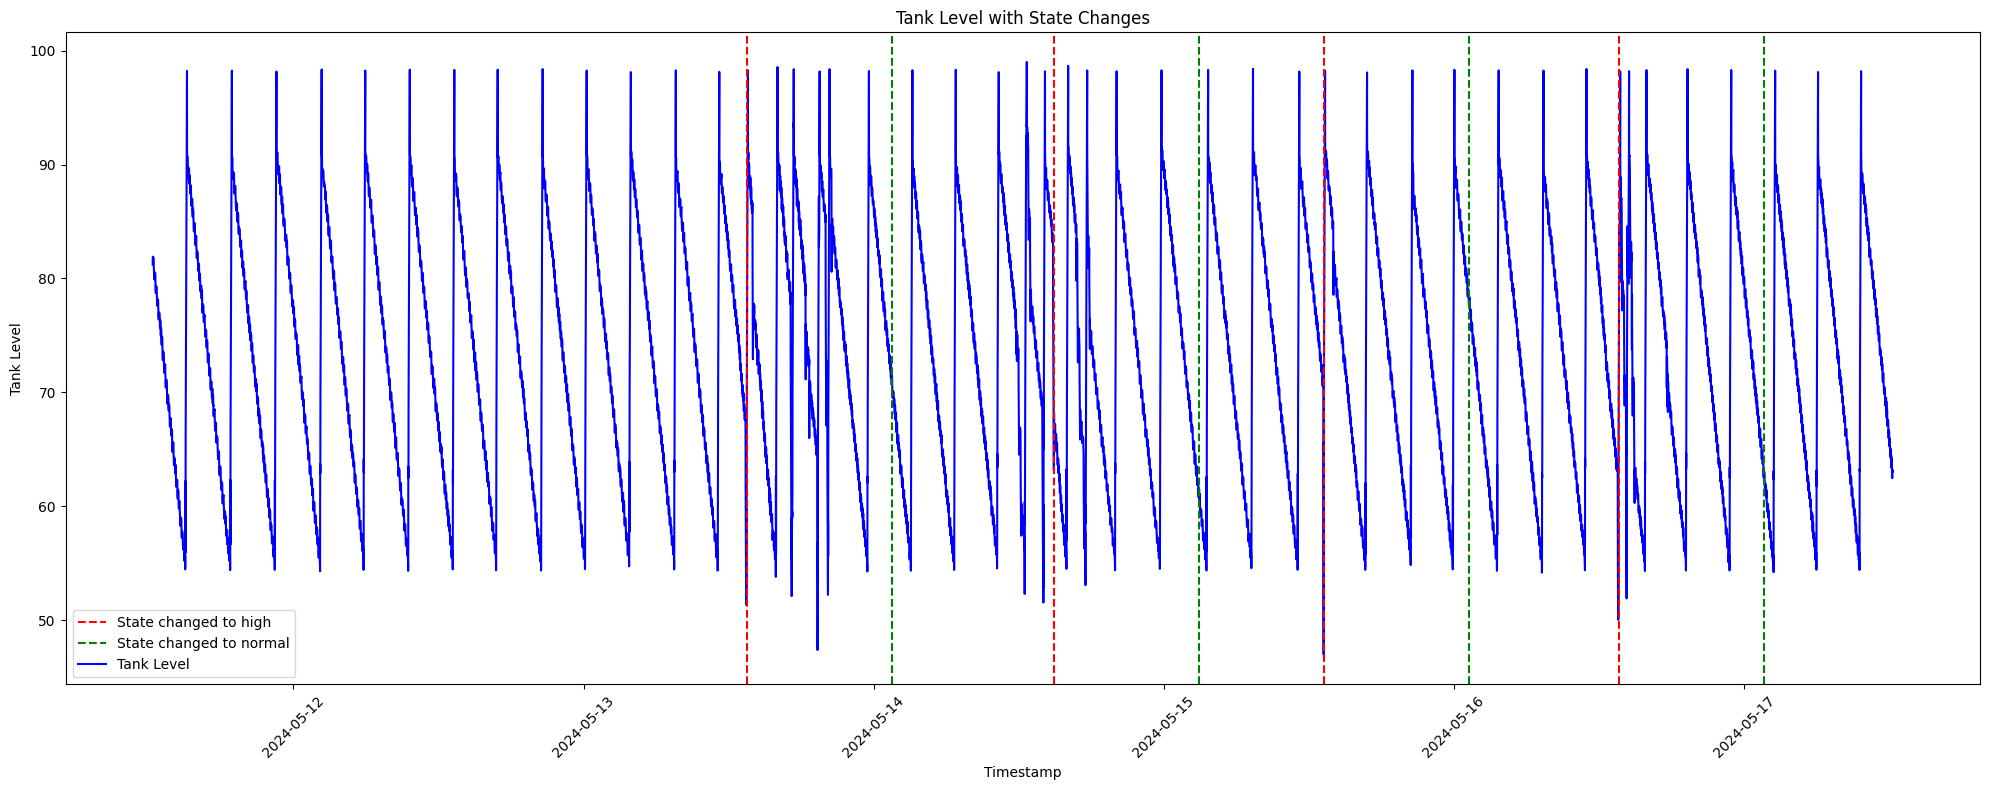

Total state changes: 8
State changed to high at 2024-05-13 13:30:49.764007+00:00
State changed to normal at 2024-05-14 01:31:55.014007+00:00
State changed to high at 2024-05-14 14:52:54.514007+00:00
State changed to normal at 2024-05-15 02:53:02.014007+00:00
State changed to high at 2024-05-15 13:13:11.263000+00:00
State changed to normal at 2024-05-16 01:13:30.513000+00:00
State changed to high at 2024-05-16 13:38:42.013000+00:00
State changed to normal at 2024-05-17 01:39:13.265014+00:00


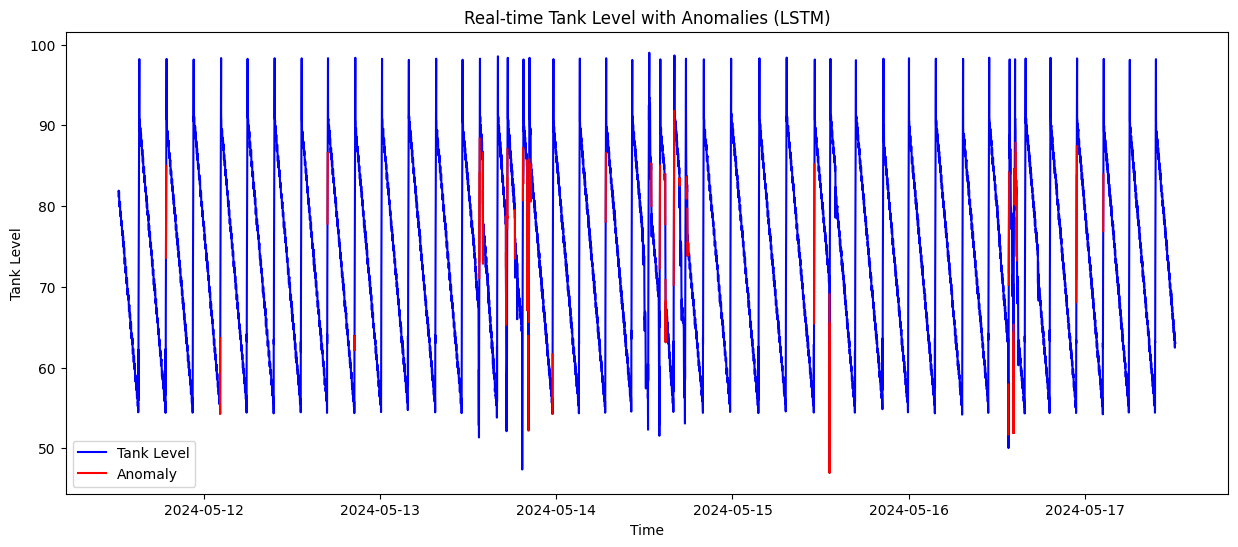

2024-04-19 12:20:51+00
2024-05-11 12:20:51+00
Training started NOW
X_realtime [[61.0875    61.0875    59.9624977 60.7812538 60.9125023]
 [61.0875    59.9624977 60.7812538 60.9125023 60.09375  ]
 [59.9624977 60.7812538 60.9125023 60.09375   59.05625  ]
 ...
 [74.775     75.3375    75.475     78.05      79.125    ]
 [75.3375    75.475     78.05      79.125     81.       ]
 [75.475     78.05      79.125     81.        83.6125   ]]
Epoch 1/100
868/868 [==============================] - 8s 6ms/step - loss: 71.9189 - val_loss: 0.3705
Epoch 2/100
868/868 [==============================] - 5s 6ms/step - loss: 0.2625 - val_loss: 0.2322
Epoch 3/100
868/868 [==============================] - 5s 6ms/step - loss: 0.2065 - val_loss: 0.2114
Epoch 4/100
868/868 [==============================] - 5s 6ms/step - loss: 0.1952 - val_loss: 0.2121
Epoch 5/100
868/868 [==============================] - 5s 6ms/step - loss: 0.1857 - val_loss: 0.3204
Epoch 6/100
868/868 [==============================] - 5s 6ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


X_realtime [[61.0875    61.0875    59.9624977 60.7812538 60.9125023]
 [61.0875    59.9624977 60.7812538 60.9125023 60.09375  ]
 [59.9624977 60.7812538 60.9125023 60.09375   59.05625  ]
 ...
 [74.775     75.3375    75.475     78.05      79.125    ]
 [75.3375    75.475     78.05      79.125     81.       ]
 [75.475     78.05      79.125     81.        83.6125   ]]
Epoch 1/100
868/868 [==============================] - 7s 6ms/step - loss: 90.5096 - val_loss: 0.3854
Epoch 2/100
868/868 [==============================] - 5s 5ms/step - loss: 0.3580 - val_loss: 0.2992
Epoch 3/100
868/868 [==============================] - 5s 5ms/step - loss: 0.2168 - val_loss: 0.2105
Epoch 4/100
868/868 [==============================] - 5s 6ms/step - loss: 0.2098 - val_loss: 0.2785
Epoch 5/100
868/868 [==============================] - 5s 5ms/step - loss: 0.1816 - val_loss: 0.1615
Epoch 6/100
868/868 [==============================] - 5s 5ms/step - loss: 0.1909 - val_loss: 0.1699
Epoch 7/100
868/868 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model loaded successfully for monitoring.
hiiiii
2024-05-11 12:37:30+00
2024-05-17 12:37:30+00
Current State normal
last_stage_change_time 2024-05-17 12:37:31
{'data': {'getRawHistoryDataWithSampling': [{'ts': '2024-03-14T00:44:13.007003+00:00', 'floatvalue': None, 'stringvalue': '0'}, {'ts': '2024-04-06T12:31:33.265014+00:00', 'floatvalue': 72.56875, 'stringvalue': None}, {'ts': '2024-04-06T12:33:01.265014+00:00', 'floatvalue': 72.0875, 'stringvalue': None}, {'ts': '2024-04-06T12:33:21.265014+00:00', 'floatvalue': 71.9562454, 'stringvalue': None}, {'ts': '2024-04-06T12:33:31.265014+00:00', 'floatvalue': 72.5125046, 'stringvalue': None}, {'ts': '2024-04-06T12:33:51.265014+00:00', 'floatvalue': 72.625, 'stringvalue': None}, {'ts': '2024-04-06T12:38:59.264999+00:00', 'floatvalue': 72.5187454, 'stringvalue': None}, {'ts': '2024-04-06T12:39:21.264007+00:00', 'floatvalue': 71.7125, 'stringvalue': None}, {'ts': '2024-04-06T12:40:39.264999+00:00', 'floatvalue': 71.025, 'stringvalue': None}, {

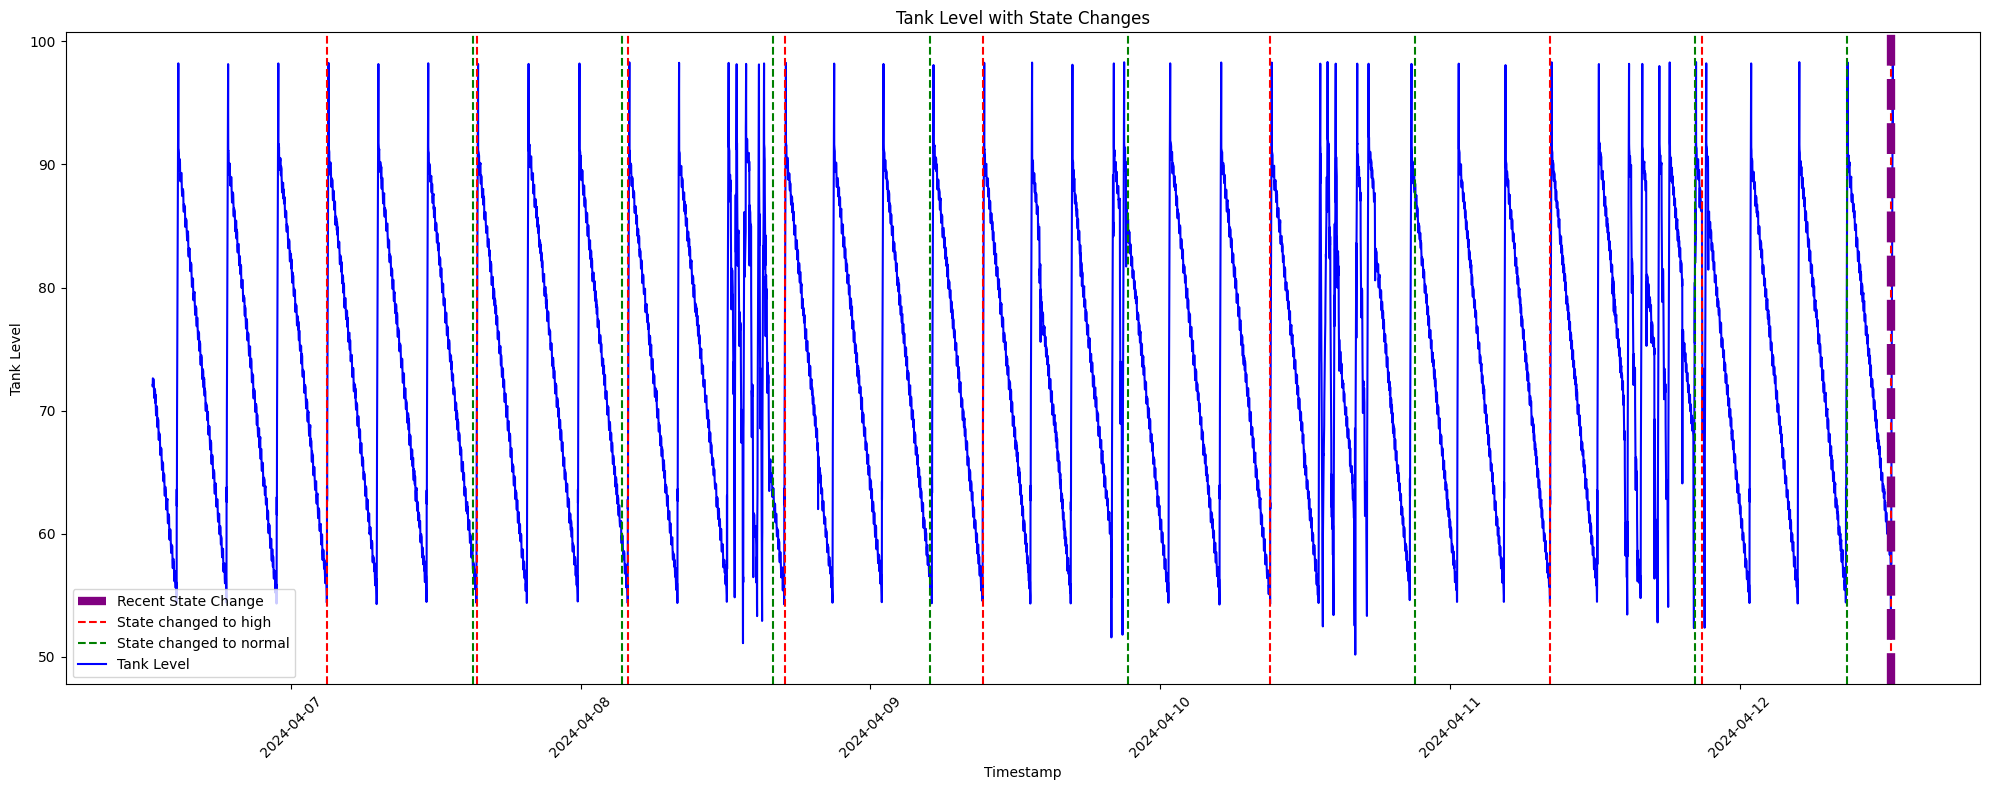

Total state changes: 17
State changed to high at 2024-04-07 03:00:37.014007+00:00
State changed to normal at 2024-04-07 15:02:32.264999+00:00
State changed to high at 2024-04-07 15:23:20.265014+00:00
State changed to normal at 2024-04-08 03:23:25.764007+00:00
State changed to high at 2024-04-08 03:54:07.763000+00:00
State changed to normal at 2024-04-08 15:54:48.914001+00:00
State changed to high at 2024-04-08 16:53:19.264999+00:00
State changed to normal at 2024-04-09 04:54:20.514007+00:00
State changed to high at 2024-04-09 09:18:53.014007+00:00
State changed to normal at 2024-04-09 21:20:24.264007+00:00
State changed to high at 2024-04-10 09:07:25.765014+00:00
State changed to normal at 2024-04-10 21:07:41.014007+00:00
State changed to high at 2024-04-11 08:18:28.264007+00:00
State changed to normal at 2024-04-11 20:18:53.766006+00:00
State changed to high at 2024-04-11 20:52:09.764999+00:00
State changed to normal at 2024-04-12 08:52:25.014007+00:00
State changed to high at 2024-04

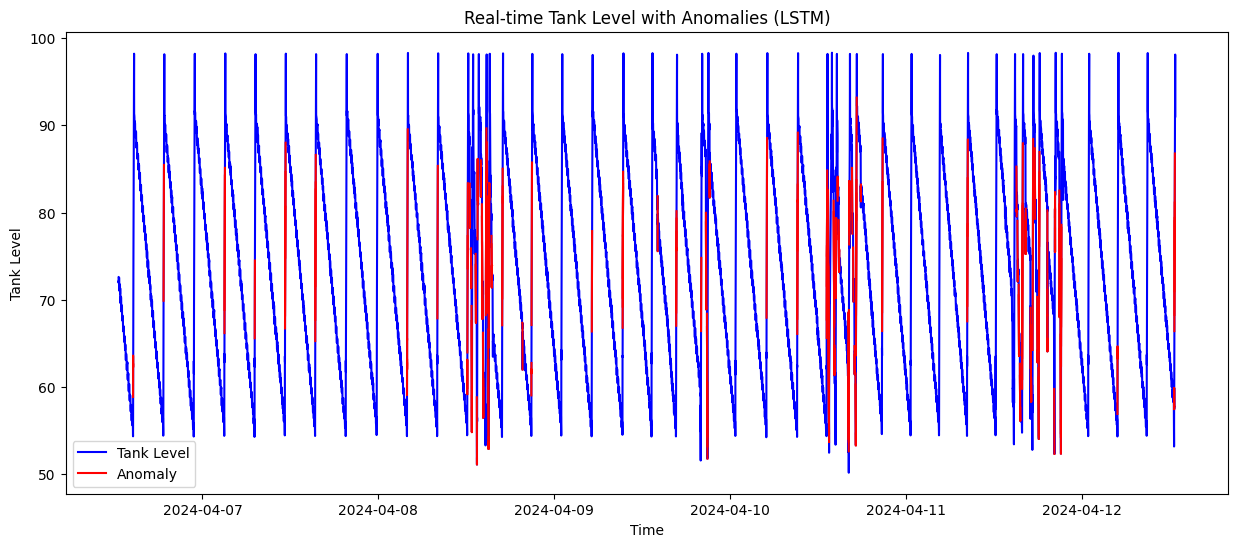

Model loaded successfully for monitoring.
hiiiii
2024-05-11 12:37:37+00
2024-05-17 12:37:37+00
Current State high
last_stage_change_time 2024-04-12 12:31:17
{'data': {'getRawHistoryDataWithSampling': [{'ts': '2024-03-14T00:44:13.007003+00:00', 'floatvalue': None, 'stringvalue': '0'}, {'ts': '2024-04-06T12:31:33.265014+00:00', 'floatvalue': 72.56875, 'stringvalue': None}, {'ts': '2024-04-06T12:33:01.265014+00:00', 'floatvalue': 72.0875, 'stringvalue': None}, {'ts': '2024-04-06T12:33:21.265014+00:00', 'floatvalue': 71.9562454, 'stringvalue': None}, {'ts': '2024-04-06T12:33:31.265014+00:00', 'floatvalue': 72.5125046, 'stringvalue': None}, {'ts': '2024-04-06T12:33:51.265014+00:00', 'floatvalue': 72.625, 'stringvalue': None}, {'ts': '2024-04-06T12:38:59.264999+00:00', 'floatvalue': 72.5187454, 'stringvalue': None}, {'ts': '2024-04-06T12:39:21.264007+00:00', 'floatvalue': 71.7125, 'stringvalue': None}, {'ts': '2024-04-06T12:40:39.264999+00:00', 'floatvalue': 71.025, 'stringvalue': None}, {'t

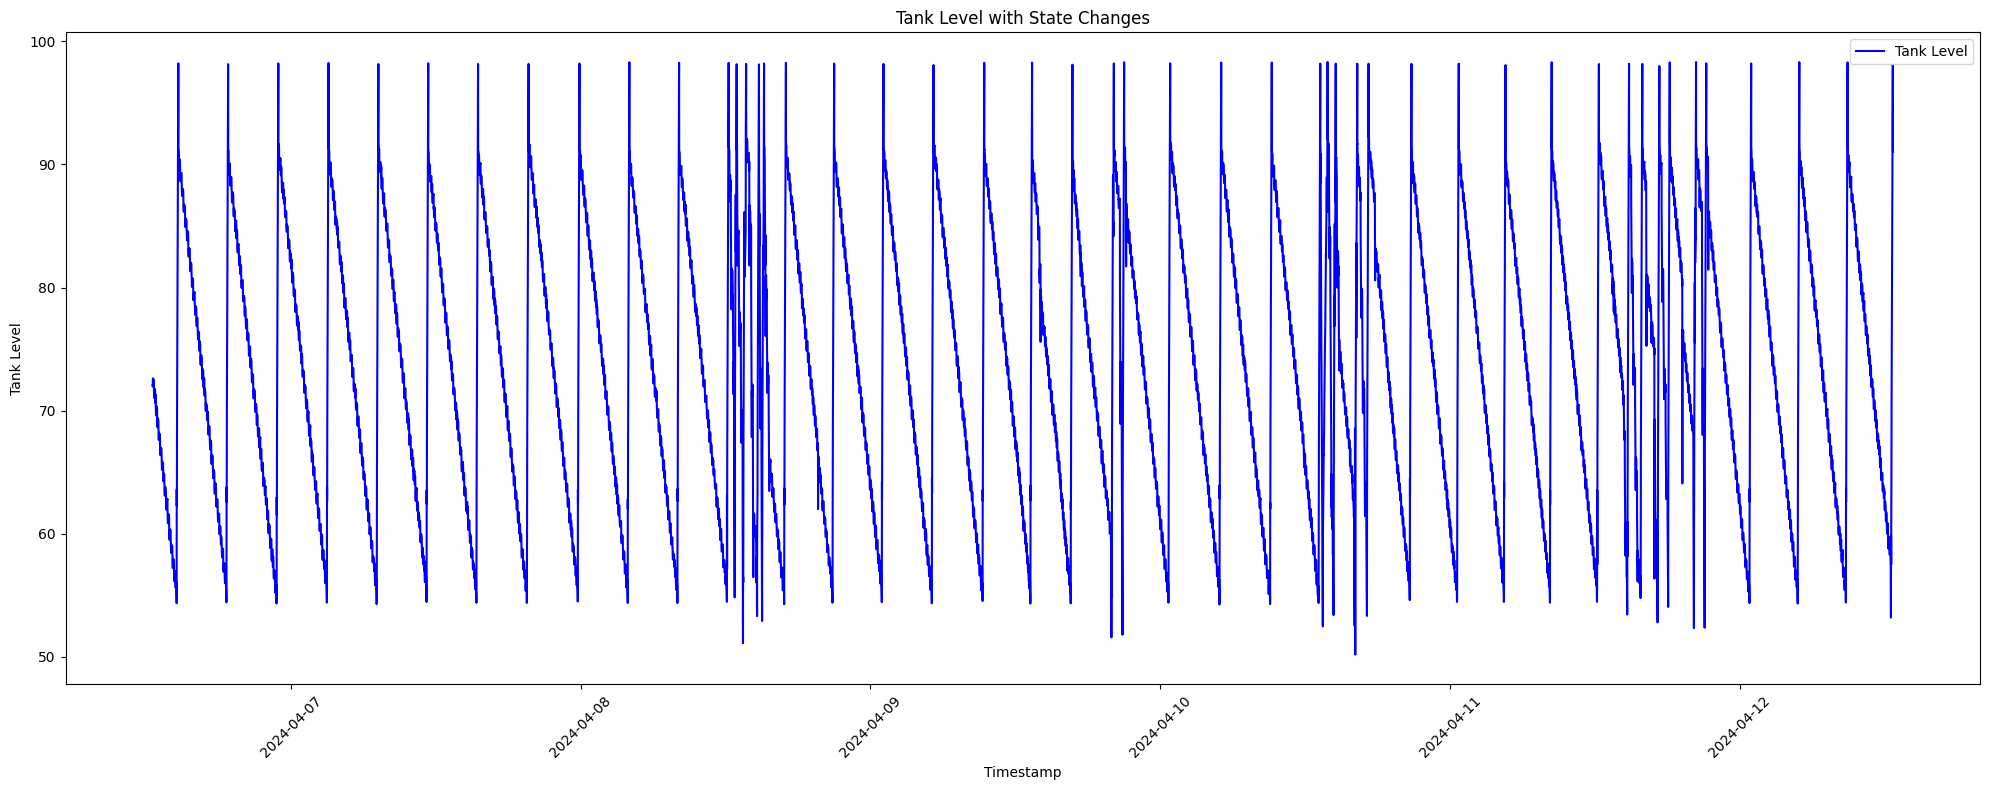

Total state changes: 0


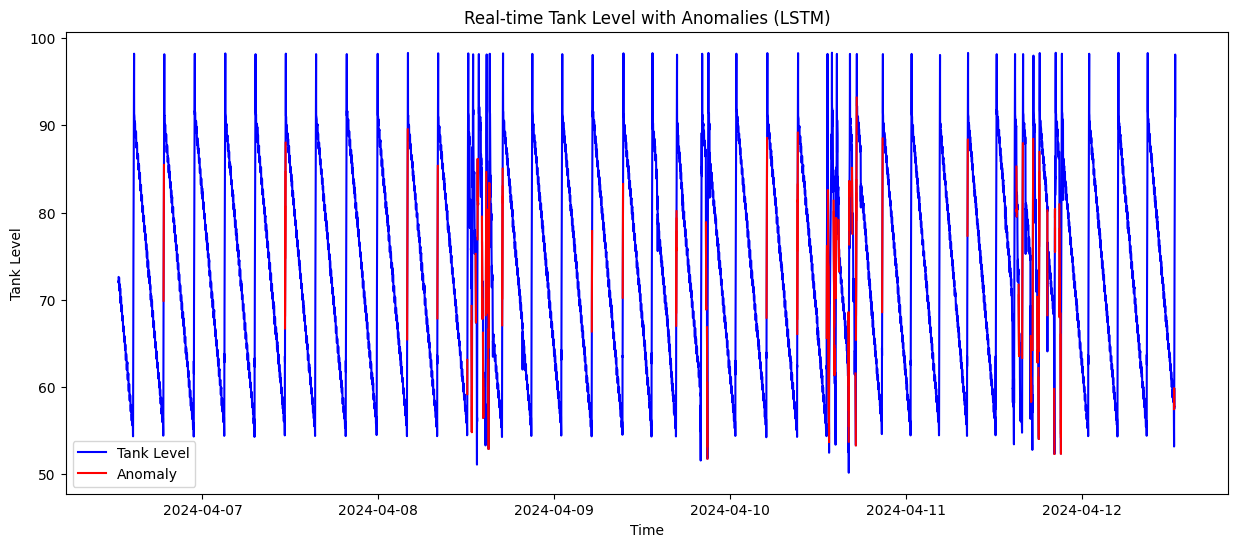

Model loaded successfully for monitoring.
hiiiii
2024-05-11 12:37:43+00
2024-05-17 12:37:43+00
Current State high
last_stage_change_time 2024-04-12 12:31:17
{'data': {'getRawHistoryDataWithSampling': [{'ts': '2024-03-14T00:44:13.007003+00:00', 'floatvalue': None, 'stringvalue': '0'}, {'ts': '2024-04-06T12:31:33.265014+00:00', 'floatvalue': 72.56875, 'stringvalue': None}, {'ts': '2024-04-06T12:33:01.265014+00:00', 'floatvalue': 72.0875, 'stringvalue': None}, {'ts': '2024-04-06T12:33:21.265014+00:00', 'floatvalue': 71.9562454, 'stringvalue': None}, {'ts': '2024-04-06T12:33:31.265014+00:00', 'floatvalue': 72.5125046, 'stringvalue': None}, {'ts': '2024-04-06T12:33:51.265014+00:00', 'floatvalue': 72.625, 'stringvalue': None}, {'ts': '2024-04-06T12:38:59.264999+00:00', 'floatvalue': 72.5187454, 'stringvalue': None}, {'ts': '2024-04-06T12:39:21.264007+00:00', 'floatvalue': 71.7125, 'stringvalue': None}, {'ts': '2024-04-06T12:40:39.264999+00:00', 'floatvalue': 71.025, 'stringvalue': None}, {'t

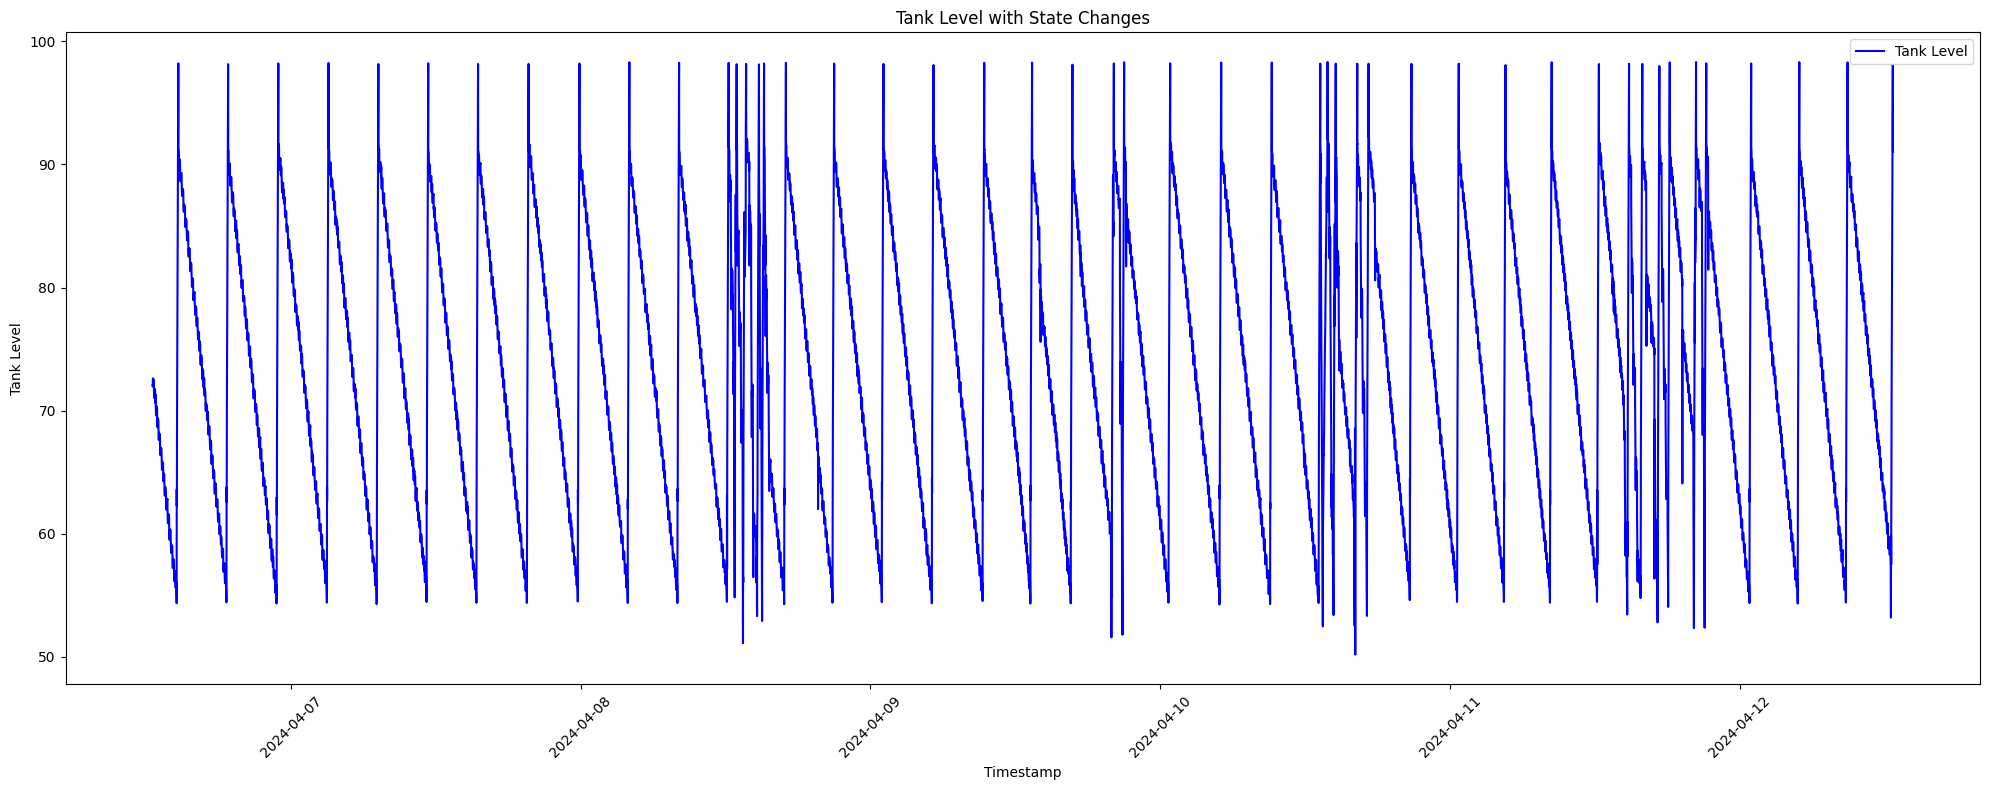

Total state changes: 0


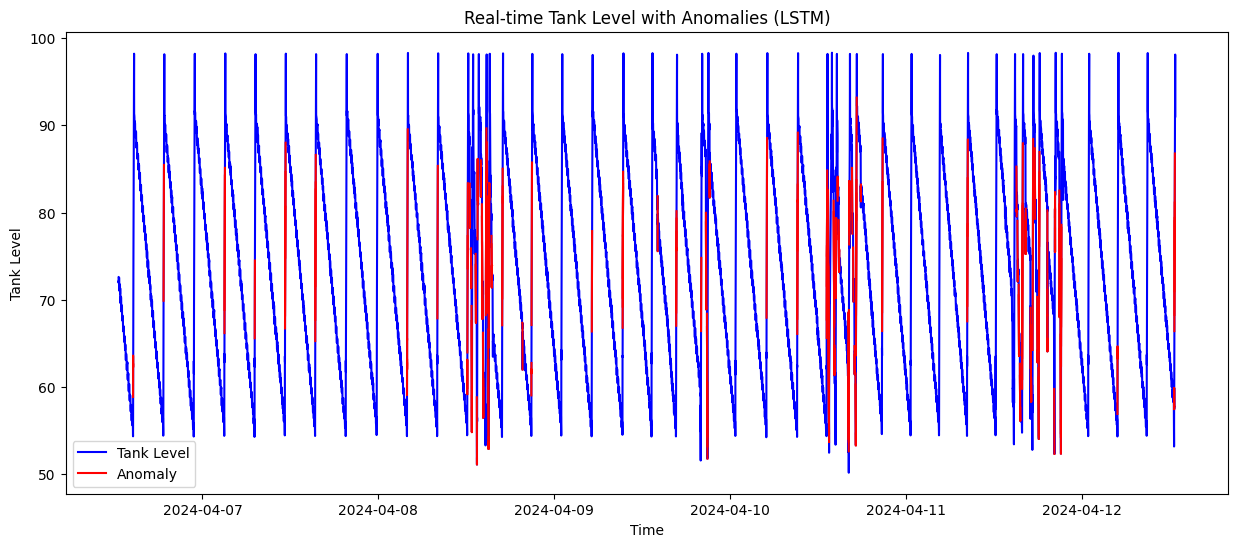

2024-04-19 12:37:48+00
2024-05-11 12:37:48+00
Training started NOW
X_realtime [[70.0875    70.0875    69.025     69.7125    70.0125   ]
 [70.0875    69.025     69.7125    70.0125    69.99375  ]
 [69.025     69.7125    70.0125    69.99375   69.94375  ]
 ...
 [60.33125   60.125     60.6875    60.8437462 60.8812523]
 [60.125     60.6875    60.8437462 60.8812523 59.95     ]
 [60.6875    60.8437462 60.8812523 59.95      59.3125   ]]
Epoch 1/100
829/829 [==============================] - 7s 7ms/step - loss: 163.0794 - val_loss: 0.2978
Epoch 2/100
829/829 [==============================] - 5s 6ms/step - loss: 0.3028 - val_loss: 0.1528
Epoch 3/100
829/829 [==============================] - 5s 6ms/step - loss: 0.2064 - val_loss: 0.1724
Epoch 4/100
829/829 [==============================] - 5s 6ms/step - loss: 0.1830 - val_loss: 0.1104
Epoch 5/100
829/829 [==============================] - 5s 6ms/step - loss: 0.1632 - val_loss: 0.1265
Epoch 6/100
829/829 [==============================] - 5s 6ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


X_realtime [[70.0875    70.0875    69.025     69.7125    70.0125   ]
 [70.0875    69.025     69.7125    70.0125    69.99375  ]
 [69.025     69.7125    70.0125    69.99375   69.94375  ]
 ...
 [60.33125   60.125     60.6875    60.8437462 60.8812523]
 [60.125     60.6875    60.8437462 60.8812523 59.95     ]
 [60.6875    60.8437462 60.8812523 59.95      59.3125   ]]
Epoch 1/100
829/829 [==============================] - 7s 7ms/step - loss: 208.9563 - val_loss: 0.2758
Epoch 2/100
829/829 [==============================] - 5s 6ms/step - loss: 0.2985 - val_loss: 0.1884
Epoch 3/100
829/829 [==============================] - 5s 6ms/step - loss: 0.2242 - val_loss: 0.1289
Epoch 4/100
829/829 [==============================] - 5s 6ms/step - loss: 0.1902 - val_loss: 0.1296
Epoch 5/100
829/829 [==============================] - 5s 6ms/step - loss: 0.1726 - val_loss: 0.1370
Epoch 6/100
829/829 [==============================] - 5s 6ms/step - loss: 0.1634 - val_loss: 0.1258
Epoch 7/100
829/829 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


X_realtime [[70.0875    70.0875    69.025     69.7125    70.0125   ]
 [70.0875    69.025     69.7125    70.0125    69.99375  ]
 [69.025     69.7125    70.0125    69.99375   69.94375  ]
 ...
 [60.33125   60.125     60.6875    60.8437462 60.8812523]
 [60.125     60.6875    60.8437462 60.8812523 59.95     ]
 [60.6875    60.8437462 60.8812523 59.95      59.3125   ]]
Epoch 1/100
829/829 [==============================] - 8s 7ms/step - loss: 134.2647 - val_loss: 0.4441
Epoch 2/100
829/829 [==============================] - 6s 7ms/step - loss: 0.3890 - val_loss: 0.2843
Epoch 3/100
829/829 [==============================] - 6s 7ms/step - loss: 0.3575 - val_loss: 0.2946
Epoch 4/100
829/829 [==============================] - 6s 7ms/step - loss: 0.3077 - val_loss: 0.2080
Epoch 5/100
829/829 [==============================] - 5s 6ms/step - loss: 0.2403 - val_loss: 0.2540
Epoch 6/100
829/829 [==============================] - 5s 7ms/step - loss: 0.2194 - val_loss: 0.2015
Epoch 7/100
829/829 [======

In [ ]:
def real_time_monitoring():
    start_time, end_time = generate_query_timestamps(6)
    model_path = 'lstm_model.h5'
    if not os.path.exists(model_path):
        print("Model file not found. Please train the model first.")
        return  # Exit the function if model is not found

    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully for monitoring.")

    print("hiiiii")
    print(start_time)
    print(end_time)
    state_info = load_state_info()
    current_state = state_info['current_state']
    print("Current State", current_state)
    utc_zone = tz.tzutc()
    last_state_change_time = datetime.strptime(state_info['last_state_change_time'], '%Y-%m-%d %H:%M:%S+00:00')
    print("last_stage_change_time",last_state_change_time)
    now = datetime.now(pytz.utc)
    should_save_state_info = False

    authenticator = "Anish"
    password = "Msdhoni#7ncsu"
    name = "atoorpu"
    role = "ncsu_group"
    instance_graphql_endpoint = "https://ncsu.cesmii.net/graphql"


    graphql_query = f"""
    query HistoryQuery {{
        getRawHistoryDataWithSampling(
            maxSamples: 0
            ids: ["764692","764782"]
            startTime: "{start_time}"
            endTime: "{end_time}"
        ) {{
            ts
            floatvalue
            stringvalue
        }}
    }}
    """

    # Here you would fetch and preprocess your data to get X_realtime
    # For example, let's assume you've done this and have your data ready in X_realtime
    response_data = perform_graphql_request(graphql_query, instance_graphql_endpoint, authenticator, password, name, role)
    print(response_data)


    # Extract data from response
    data = response_data["data"]["getRawHistoryDataWithSampling"]
    print(data)

    stringvalue_dict = preprocess_data(data)

    sequence_length = 5
    X_realtime,pre_df = preprocess_realtime_data(stringvalue_dict, sequence_length)

    print("pre_df",pre_df)
    print(len(pre_df))

    predictions = model.predict(X_realtime)
    predictions = predictions.squeeze(axis=-1)
    print("predictions",predictions)
    if pre_df.index.tzinfo is None or pre_df.index.tzinfo.utcoffset(pre_df.index[0]) is None:
        pre_df.index = pd.to_datetime(pre_df.index).tz_localize(tz.tzutc())
    else:
        pre_df.index = pre_df.index.tz_convert(tz.tzutc())

    # start_time="2024-04-06 12:32:33.513000+00:00"
    # end_time="2024-04-12 03:15:59.514999+00:00"
    pre_df_filtered = pre_df[(pre_df.index >= pd.to_datetime(start_time)) & (pre_df.index <= pd.to_datetime(end_time))]
    print("pre_df_filtered",pre_df_filtered)
    print(len(pre_df_filtered))


    # Include your anomaly detection and state change logic here
    switch_states_realtime = np.array([entry['RO_Skid_Running'] for entry in stringvalue_dict.values()][sequence_length - 1:])
    print(switch_states_realtime)

    reconstruction_errors_realtime = np.mean(np.square(X_realtime - predictions), axis=1)
    print(reconstruction_errors_realtime)

    level_pv_last_values = [sequence[-1] for sequence in X_realtime]

    off_state_errors_adjusted = reconstruction_errors_realtime[(switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85)]

    threshold_realtime_adjusted = np.percentile(off_state_errors_adjusted, 97)
    #threshold_realtime_adjusted = adaptive_percentile_threshold(off_state_errors_adjusted, window_size=100, percentile=95)
    print("threshold_realtime_adjusted",threshold_realtime_adjusted)

    anomalies_realtime_adjusted = np.where((reconstruction_errors_realtime > threshold_realtime_adjusted) & (switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85))[0]
    print(anomalies_realtime_adjusted)

    filtered_anomalies_realtime_adjusted = filter_anomalies(anomalies_realtime_adjusted)
    last_state_change_time = last_state_change_time.replace(tzinfo=tz.tzutc())
    # Example update of state_info (this should be replaced with your actual logic)
    anomaly_presence_threshold = 2 # Threshold for consecutive anomalies to consider a state change
    persistence_requirement = timedelta(hours=12)  # Required duration for anomalies to persist

    # Initialize variables for state monitoring
    state_changes = []
    current_anomaly_sequence = 0
    print(current_state)

    local_current_state = current_state  # Start with the global state
    local_last_state_change_time = last_state_change_time  # Start with the global last change time

    # Process anomalies and determine state changes
    for i in range(len(pre_df_filtered)):
        is_anomaly = i in filtered_anomalies_realtime_adjusted
        time_since_last_change = pre_df_filtered.index[i] - local_last_state_change_time

        if is_anomaly:
            current_anomaly_sequence += 1
        else:
            current_anomaly_sequence = 0

        state_changed = False
        new_state = None
        if current_anomaly_sequence >= anomaly_presence_threshold and local_current_state == "normal":
            new_state = "high"
            local_current_state = new_state  # Update local state
            local_last_state_change_time = pre_df_filtered.index[i]  # Update local time of change
            state_changes.append((local_last_state_change_time, local_current_state))

        elif not is_anomaly and local_current_state == "high" and time_since_last_change >= persistence_requirement:
            new_state = "normal"
            local_current_state = new_state  # Update local state
            local_last_state_change_time = pre_df_filtered.index[i]  # Update local time of change
            state_changes.append((local_last_state_change_time, local_current_state))


    print("current state", current_state)
    print("state_changes",state_changes)
    recent_state_changes=[]

    # utc_now = datetime.now(pytz.utc)
    # time = "2024-04-12 03:15:59.514999+00:00"
    # utc_now = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f%z')
    utc_zone = pytz.utc
    utc_now = datetime.now(utc_zone)
    fifteen_minutes_ago = utc_now - timedelta(minutes=15)
    print("fifteen minutes ago",fifteen_minutes_ago)

    # Filter state changes that occurred within the last 15 minutes
    recent_state_changes = [change for change in state_changes if change[0] >= fifteen_minutes_ago]
    print(recent_state_changes)

    for change_time, new_state in recent_state_changes:
      print(change_time)
      print(new_state)


    # Check if there are any recent changes and process them
    should_save_state_info = False
    for change_time, new_state in recent_state_changes:
        print("new_state",new_state)
        print("current_state",current_state)
        print(new_state != current_state)
        if new_state != current_state:
            # Update the current state and the time of change
            current_state = new_state
            last_state_change_time = change_time
            should_save_state_info = True


            original_plot_buffer, zoomed_plot_buffer = create_plot(pre_df_filtered, state_changes, recent_state_changes)
            original_plot_image = plt.imread(original_plot_buffer)
            zoomed_plot_image = plt.imread(zoomed_plot_buffer)

            # # Display original plot
            # plt.figure(figsize=(20, 8))
            # plt.imshow(original_plot_image)
            # plt.axis('off')
            # plt.title('Original Plot')
            # plt.show()

            # # Display zoomed plot
            # plt.figure(figsize=(20, 8))
            # plt.imshow(zoomed_plot_image)
            # plt.axis('off')
            # plt.title('Zoomed Plot (Last 15 minutes)')
            # plt.show()

            # Prepare and send email about the state change
            subject = f"CESMII SMIP: HPW V8000 State Change Notification: {current_state}"

            est_timezone = pytz.timezone('America/New_York')

            # Convert last_state_change_time to EST and format it
            last_state_change_time_est = last_state_change_time.astimezone(est_timezone).strftime('%Y-%m-%d %H:%M:%S')

            # Customizing the message for each state change
            if new_state == "high":
                message = (f"The HPW system V8000 has entered a state of high water demand as of {last_state_change_time_est}. "
                   "Please change V8000 process setpoints to the following:\n\n"
                   "Return Pressure Setpoint: 44 psig\n"
                   "Supply Pressure Setpoint: 78 psig")
            else:
                message = (f"The HPW system V8000 has entered a normal state with low water usage as of {last_state_change_time_est}. "
                   "Please change V8000 process setpoints to the following:\n\n"
                   "Return Pressure Setpoint: 40 psig\n"
                   "Supply Pressure Setpoint: 64 psig")
            send_email(subject, message, original_plot_buffer, zoomed_plot_buffer)

    if should_save_state_info:
        # Save the state info if there's a recent change
        updated_state_info = {
            "current_state": current_state,
            "last_state_change_time": last_state_change_time.strftime('%Y-%m-%d %H:%M:%S+00:00')
        }
        save_state_info(updated_state_info)
    else:
        # Log a message if no recent changes occurred
        print("No recent changes. Retaining previous state.")

    print("Recent changes within the last 15 minutes:", [f"State changed to {s[1]} at {s[0].strftime('%Y-%m-%d %H:%M:%S+00:00')}" for s in recent_state_changes])

    plt.figure(figsize=(20, 8))
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot vertical lines for all state changes
    for change_time, state in state_changes:
        if state == "high":
            color = 'red'
        else:
            color = 'green'
        plt.axvline(x=change_time, color=color, linestyle='--', label=f'State changed to {state}')

    # Highlight recent state changes in purple
    for change_time, state in recent_state_changes:
        plt.axvline(x=change_time, color='purple', linestyle='--', linewidth=6, label='Recent State Change')

    # This part ensures that each state change label is only added to the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels_handles = dict(zip(labels, handles)).items()
    sorted_handles_labels = sorted(unique_labels_handles)  # Sort or customize as needed
    plt.legend([handle for label, handle in sorted_handles_labels], [label for label, handle in sorted_handles_labels])

    plt.title('Tank Level with State Changes')
    plt.xlabel('Timestamp')
    plt.ylabel('Tank Level')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Display the number of state changes
    print(f"Total state changes: {len(state_changes)}")
    for change_time, state in state_changes:
        print(f"State changed to {state} at {change_time}")

    plt.figure(figsize=(15, 6))

    # Plot the tank level
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot the anomalies using plt.plot
    for anomaly in filtered_anomalies_realtime_adjusted:
        anomaly_start_index = anomaly
        anomaly_end_index = anomaly + sequence_length
        # Plot the segment of the anomaly
        plt.plot(pre_df_filtered.index[anomaly_start_index:anomaly_end_index],
                pre_df_filtered['Level_PV'][anomaly_start_index:anomaly_end_index],
                'r-', label='Anomaly' if 'Anomaly' not in [l.get_label() for l in plt.gca().get_lines()] else "")

    plt.legend()
    plt.title('Real-time Tank Level with Anomalies (LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Tank Level')
    plt.show()

# Schedule the real_time_monitoring function to run every minute
# schedule.every(15).minutes.do(real_time_monitoring)

if __name__ == "__main__":
    if not os.path.exists('lstm_model.h5'):
        print("No model found. Training now...")
        train_and_save_model()

    # Initial monitoring to start the process
    real_time_monitoring()

    # Set up scheduled tasks
    # schedule.every(30).days.do(train_and_save_model)
    schedule.every(30).minutes.do(train_and_save_model)
    schedule.every(15).minutes.do(real_time_monitoring)

    while True:
        schedule.run_pending()
        time.sleep(1)

**This is written for sample logging in cesmii platorm using thinkiq.context.**

In [ ]:
from thinkiq_context import get_context
context = get_context()                                 # the context object holds runtime information such as the equipment id and data stored between runs
equipment_id = context.std_inputs.node_id               # the id of the equipment instance to use
print(context.std_inputs.parent_id)

from thinkiq.model.equipment import Equipment
from thinkiq.model.node import Node
eqpt = Node.get_from_id(equipment_id)              # creates an object for this equipment item
context.logger.info(f'Running script {context.std_inputs.script_name} on {eqpt.display_name}')   # shows how to use the context object and equipment model
context.return_data({  "brand": "Ford",  "model": "Mustang",  "year": 1964})